In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [1]:
#hide
from fastbook import *

# Other Computer Vision Problems

## Multi-Label Classification

### The Data

In [2]:
path = Path("/storage/data/pascal_2007/")
path.ls()

(#8) [Path('/storage/data/pascal_2007/train'),Path('/storage/data/pascal_2007/test.json'),Path('/storage/data/pascal_2007/segmentation'),Path('/storage/data/pascal_2007/train.json'),Path('/storage/data/pascal_2007/valid.json'),Path('/storage/data/pascal_2007/test.csv'),Path('/storage/data/pascal_2007/train.csv'),Path('/storage/data/pascal_2007/test')]

In [5]:
(path/'train').ls()

(#5012) [Path('/storage/data/pascal_2007/train/003772.jpg'),Path('/storage/data/pascal_2007/train/006066.jpg'),Path('/storage/data/pascal_2007/train/003767.jpg'),Path('/storage/data/pascal_2007/train/006547.jpg'),Path('/storage/data/pascal_2007/train/008444.jpg'),Path('/storage/data/pascal_2007/train/008024.jpg'),Path('/storage/data/pascal_2007/train/007361.jpg'),Path('/storage/data/pascal_2007/train/002757.jpg'),Path('/storage/data/pascal_2007/train/001341.jpg'),Path('/storage/data/pascal_2007/train/003296.jpg')...]

In [6]:
# df = pd.read_csv("/storage/data/pascal_2007/test.csv")
# df.head()

In [3]:
df = pd.read_csv("/storage/data/pascal_2007/train.csv")

In [4]:
def get_x(series): return Path(f'/storage/data/pascal_2007/train/{series["fname"]}')
def get_y(series): return series['labels'].split()
def splitter(pd):
    train = pd.index[~df['is_valid']].tolist() 
    valid = pd.index[df['is_valid']].tolist()
    return train,valid

with no_random():
    datablock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                          get_x=get_x,
                          get_y=get_y,
                          item_tfms=Resize(460),
                          batch_tfms=aug_transforms(size=128, min_scale=0.75),
                          splitter=splitter)
    dls = datablock.dataloaders(df)

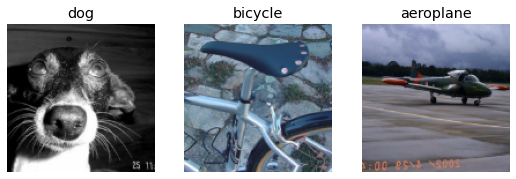

In [10]:
dls.show_batch(max_n=3)

### Sidebar: Pandas and DataFrames

### End sidebar

### Constructing a DataBlock

In [ ]:
df.iloc[0]

### Binary Cross-Entropy

## Regression

In [5]:
with no_random():
    learner = vision_learner(dls, resnet18, metrics=accuracy_multi)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
x,y = to_cpu(dls.train.one_batch())

In [ ]:
activs = learner.model(x)
activs.shape

### Training and checking improving results

Let's do some model training, checkout loss and accuracy, then try to find the best learning rate and change some transformations to see the impacts.

##### Loss Function

Since this is a classification setting, we want to scale the result to be between `0` and `1` before doing a loss calculation. We also want to take the log after taking the difference.

In [6]:
with no_random():
    learner.fine_tune(epochs=5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.929548,0.628511,0.669143,00:24


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.738293,0.544774,0.745697,00:20
1,0.615083,0.352269,0.904024,00:20
2,0.451785,0.215757,0.949522,00:19
3,0.335657,0.177923,0.953785,00:20
4,0.272257,0.172513,0.954243,00:20


(0.03019951581954956, 0.03981071710586548)

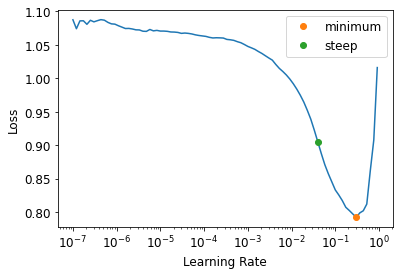

In [9]:
with no_random():
    learner = vision_learner(dls, resnet18, metrics=accuracy_multi)
    lr_min, lr_steep = learner.lr_find(suggest_funcs=(minimum,steep))

lr_min,lr_steep

In [10]:
with no_random():
    learner.fit_one_cycle(3, 3e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.462889,0.350319,0.911335,00:17
1,0.278342,0.171554,0.941992,00:17
2,0.202039,0.135280,0.950837,00:17


(1.58489319801447e-07, 3.981071586167673e-06)

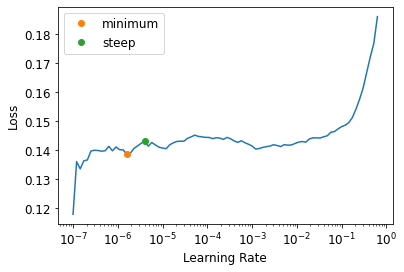

In [11]:
with no_random():
    lr_min, lr_steep = learner.lr_find(suggest_funcs=(minimum,steep))
    
lr_min, lr_steep

In [12]:
learner.unfreeze()
learner.fit_one_cycle(6, 1e-6)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.147485,0.135791,0.950717,00:17
1,0.146566,0.135686,0.950857,00:17
2,0.143757,0.134520,0.950797,00:18
3,0.143233,0.134854,0.951295,00:18
4,0.141537,0.134645,0.950956,00:17
5,0.142172,0.134461,0.950916,00:18


In [15]:
with no_random():
    learner = vision_learner(dls, resnet18, metrics=accuracy_multi)
    learner.fit_one_cycle(3, 3e-2)
    learner.unfreeze()
    learner.fit_one_cycle(6, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.469604,0.279283,0.919143,00:16
1,0.286378,0.169962,0.943904,00:17
2,0.207718,0.139767,0.950478,00:17


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.147679,0.136432,0.951374,00:18
1,0.143666,0.131865,0.952351,00:17
2,0.138550,0.128876,0.953526,00:18
3,0.130837,0.127929,0.954283,00:17
4,0.127180,0.127672,0.953924,00:17
5,0.123153,0.127262,0.954004,00:17


In [16]:
with no_random():
    interpreter = Interpretation.from_learner(learner)

,target,predicted,probabilities,loss
0,chair;diningtable;person,train,"TensorBase([3.3637e-05, 3.4560e-03, 6.0107e-04, 3.6151e-03, 4.2032e-04, 2.6682e-02, 1.1438e-02, 4.4654e-05, 1.0174e-03, 2.1831e-03, 2.5510e-04, 2.5337e-03, 9.7483e-04, 4.7614e-04, 1.3301e-01, 1.7473e-03,\n 6.6872e-05, 3.0516e-04, 9.9784e-01, 1.8619e-04])",1.1688106060028076
1,bus;car,train,"TensorBase([9.3039e-03, 1.4592e-03, 2.9276e-03, 2.3185e-02, 1.8513e-04, 5.0128e-03, 8.8343e-03, 1.4350e-04, 1.0952e-03, 3.0724e-02, 2.6942e-04, 6.8138e-03, 7.9254e-04, 1.6496e-03, 5.0482e-02, 1.9045e-03,\n 2.0719e-03, 2.9849e-04, 9.9062e-01, 1.8509e-04])",0.7414820790290833
2,bicycle;bus;car;person,,"TensorBase([5.0535e-02, 5.8022e-03, 4.7608e-03, 1.1679e-02, 9.5585e-04, 4.7762e-03, 9.4765e-02, 1.2666e-03, 5.8994e-04, 9.1531e-03, 7.6516e-05, 2.1967e-03, 3.5556e-03, 1.2384e-01, 4.6910e-01, 6.1297e-04,\n 4.4775e-04, 3.2938e-03, 3.5011e-01, 1.2604e-03])",0.7130969166755676
3,chair;diningtable,person,"TensorBase([0.0108, 0.0432, 0.0028, 0.0270, 0.0010, 0.0222, 0.2761, 0.0019, 0.0089, 0.0120, 0.0006, 0.0045, 0.0105, 0.1932, 0.5342, 0.0042, 0.0013, 0.0078, 0.2756, 0.0017])",0.699337899684906
4,dog,cat,"TensorBase([7.8004e-07, 7.3128e-06, 2.9715e-05, 3.2797e-06, 1.6451e-04, 2.5827e-06, 6.8243e-05, 9.9885e-01, 1.2227e-03, 1.1122e-03, 9.3667e-05, 8.5325e-04, 1.0047e-04, 2.1330e-05, 2.2738e-03, 2.6854e-04,\n 7.2207e-04, 5.3225e-03, 3.4886e-06, 4.0453e-04])",0.6921354532241821
5,dog;horse;person,,"TensorBase([0.0074, 0.0498, 0.0289, 0.2537, 0.0108, 0.1620, 0.2195, 0.0210, 0.0161, 0.0141, 0.0027, 0.0206, 0.0025, 0.0080, 0.0609, 0.0294, 0.0065, 0.0527, 0.0722, 0.0113])",0.685740053653717
6,aeroplane;person,train,"TensorBase([7.1902e-03, 4.4114e-03, 1.7020e-03, 5.6874e-03, 7.6596e-04, 4.3624e-03, 2.1112e-02, 4.7529e-04, 1.8717e-03, 3.1610e-02, 2.5997e-04, 6.0569e-03, 3.8472e-03, 2.5096e-02, 9.0261e-02, 1.6870e-03,\n 1.2070e-03, 9.9787e-04, 9.9423e-01, 2.9062e-03])",0.630508542060852
7,horse,dog,"TensorBase([8.9166e-07, 1.6751e-03, 1.6237e-04, 1.3503e-05, 3.2610e-04, 1.6566e-06, 6.8775e-05, 1.2034e-03, 2.4837e-04, 5.4314e-03, 1.9201e-05, 9.9121e-01, 5.0338e-04, 8.1081e-06, 1.2529e-02, 1.3462e-03,\n 2.3459e-03, 2.4795e-02, 8.2128e-06, 9.8769e-05])",0.6189679503440857
8,boat;cow;person,,"TensorBase([6.1965e-04, 1.5157e-03, 2.4670e-03, 5.0836e-04, 1.3115e-03, 1.4103e-04, 1.6295e-03, 5.9681e-03, 2.5389e-03, 3.5239e-01, 6.1247e-05, 4.0750e-01, 3.4925e-01, 8.3906e-05, 6.6332e-02, 2.8932e-03,\n 1.4803e-02, 5.0687e-03, 9.6531e-04, 6.7610e-04])",0.6167165040969849


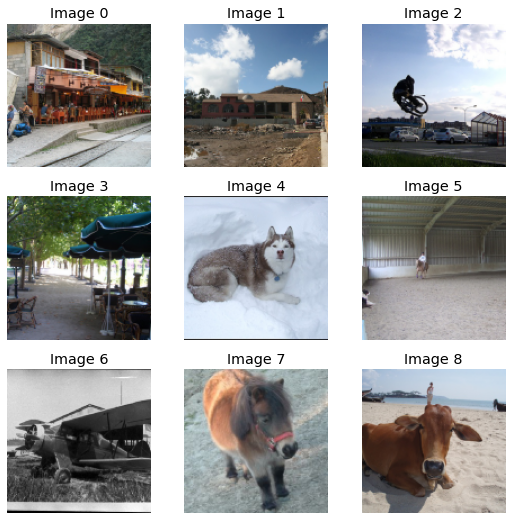

In [17]:
interpreter.plot_top_losses(10)

In [24]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

### Assemble the Data

### Training a Model

## Conclusion

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a `Dataset` and `DataLoader`?
1. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates?
1. Why is pytorch `binary_cross_entropy_with_logits` different from the custom binry crossy entropy?

1. bear classifier can then predict if image has 0 bears or multiple types of bears in same image.
1. one-hot encoding
1. df.iloc
1. df['colname']
1. Datasets contains tuple of training data, validation data.
1. Datasets has the train, validation split.
1. DataLoaders contains the split into mini-batches.
1. lambda - callable function inline
1. `get_x`, `get_y` and `blocks`
1. `softmax` rescales all elements such that they lie between `[0, 1]` and sum to `1`. Therefore, it's not appropriate when we're trying to predict multiple categories.
1. `nll_loss` expects single category
1. `nn.BCELoss` doesn't have the sigmoid scaling
1. regular accuracy assumes single class
1. not sure about this (ask in the forum)
1. regression problem is predicting a number. loss func can be RMS.
1. nothing
1. sigmoid scaling

In [4]:
F.nll_loss?

In [41]:
F.softmax?

In [34]:
df_test = pd.DataFrame({ 'colour' : ["red", "blue", "green"], 'car' : ['Merc', 'BMW', 'Merc']})
df_test

,colour,car
0,red,Merc
1,blue,BMW
2,green,Merc


In [35]:
df_test.iloc[:0,1]

Series([], Name: car, dtype: object)

In [25]:
with no_random():
    datablock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                          get_x=get_x,
                          get_y=get_y,
                          item_tfms=Resize(460),
                          batch_tfms=aug_transforms(size=128, min_scale=0.75),
                          splitter=splitter)

In [37]:
ds = datablock.datasets(df)

In [39]:
ds[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.